In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from fredapi import Fred
import warnings
warnings.filterwarnings("ignore")

fred_api_key = 'ed9cdfcec0ff880641fdd4181b851468'

### read and clean main csv

In [2]:
#df = pd.read_csv('final_v2.csv')
df = pd.read_csv('data/final_v2.csv')
print(df.head())

                  date                                              title  \
0  1999-01-03 00:00:00  Mr Ferguson reviews last year's economic perfo...   
1  1999-01-07 00:00:00  Mr Duisenberg's opening statement at the press...   
2  1999-01-14 00:00:00  Mr Duisenberg discusses the arrival of the eur...   
3  1999-01-15 00:00:00  Mr Ferguson expresses his views on monetary po...   
4  1999-01-18 00:00:00  Mr Duisenberg's opening statement at the Europ...   

                                         description  \
0  Remarks by Mr Roger W. Ferguson, Jr., a member...   
1  Introductory statement by the President of the...   
2  Speech by the President of the European Centra...   
3  Remarks by Mr Roger W. Ferguson, Jr., a member...   
4  Introductory statement by the President of the...   

                                                text               author  \
0  Mr Ferguson reviews last year's economic perfo...     Roger W Ferguson   
1  Mr Duisenberg's opening statement at the pr

In [3]:
usa_df = df[df['country'] == 'United States'][['date', 'current_rate']]
print(usa_df.head())

                  date  current_rate
0  1999-01-03 00:00:00          4.63
3  1999-01-15 00:00:00          4.63
5  1999-01-20 00:00:00          4.63
6  1999-01-21 00:00:00          4.63
7  1999-01-21 00:00:00          4.63


In [4]:
# Remove duplicate rows and keep only unique rows
usa_df = usa_df.drop_duplicates()

# Convert 'date' to just yyyy-mm-dd (string)
usa_df['date'] = pd.to_datetime(usa_df['date']).dt.strftime('%Y-%m-%d')

usa_df.set_index('date', inplace=True)

print(usa_df.head())

            current_rate
date                    
1999-01-03          4.63
1999-01-15          4.63
1999-01-20          4.63
1999-01-21          4.63
1999-01-26          4.63


In [5]:
unique_dates = usa_df.index.nunique()
duplicate_dates = usa_df.index[usa_df.index.duplicated()]
print("Duplicate dates:", duplicate_dates.unique())

Duplicate dates: Index(['2010-06-09', '2012-12-03', '2016-03-18'], dtype='object', name='date')


In [6]:
# Print rows from usa_df where the index (date) is in duplicate_dates
print(usa_df.loc[usa_df.index.isin(duplicate_dates)])

            current_rate
date                    
2010-06-09          0.18
2010-06-09          0.18
2012-12-03          0.16
2012-12-03          0.16
2016-03-18          0.36
2016-03-18          0.36


In [7]:
# Remove duplicate rows in usa_df by keeping only the first occurrence for each date
usa_df = usa_df[~usa_df.index.duplicated(keep='first')]
print(usa_df.loc[duplicate_dates])  # Check that only the first row for each duplicate date remains

            current_rate
date                    
2010-06-09          0.18
2012-12-03          0.16
2016-03-18          0.36


In [8]:
unique_dates = usa_df.index.nunique()
duplicate_dates = usa_df.index[usa_df.index.duplicated()]
print("Duplicate dates:", duplicate_dates.unique())

Duplicate dates: Index([], dtype='object', name='date')


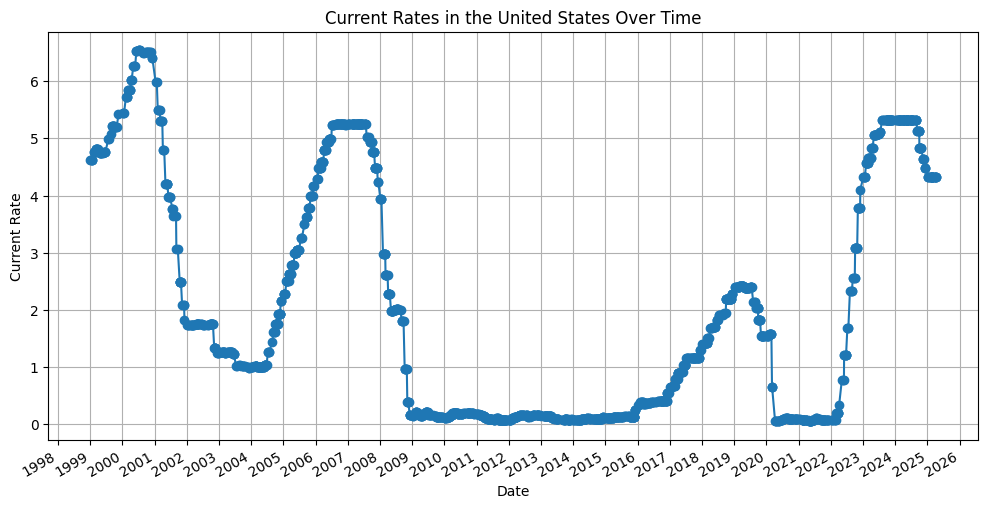

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(usa_df.index), usa_df['current_rate'], marker='o', linestyle='-')
plt.title('Current Rates in the United States Over Time')
plt.xlabel('Date')
plt.ylabel('Current Rate')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()


In [10]:
# Ensure index is datetime and sorted
usa_df = usa_df.sort_index()
print('Tot rows in usa_df:', len(usa_df))

Tot rows in usa_df: 1785


### fetch fred data

In [11]:
def fetch_us_data(fred_api_key):
    fred = Fred(api_key=fred_api_key)
    series_map = {
        'CPIAUCSL':    'inflation',     # Inflation
        'UNRATE':      'unrate',        # Unemployment Rate
        'GDPC1':       'real_gdp',      # Real GDP (Chained 2012 $)
        'T10Y2Y':      'yield_spread',  # 10yr–2yr Treasury yield spread
        'UMCSENT':     'sentiment',     # U. Mich Consumer Sentiment
        'T5YIE':       '5y_inflation',  # 5-Year Breakeven Inflation Rate
        'DCOILWTICO':  'oil_price'      # Crude Oil (WTI) price
    }
    series_dfs = {}
    for code, name in series_map.items():
        # 1) Fetch the raw series
        s = fred.get_series(code)
        df = pd.DataFrame({name: s})
        df.index = pd.to_datetime(df.index)
        df = df.resample('M').last()
        if name == 'real_gdp':
            df[name] = df[name].ffill()
        # 5) Store it
        series_dfs[name] = df

    return series_dfs

# Usage:
series_dfs = fetch_us_data(fred_api_key)
inflation_df    = series_dfs['inflation']
unrate_df       = series_dfs['unrate']
real_gdp_df     = series_dfs['real_gdp']
yield_spread_df = series_dfs['yield_spread']
sentiment_df    = series_dfs['sentiment']
fivey_inf_df    = series_dfs['5y_inflation']
oil_price_df    = series_dfs['oil_price']

# Example: inspect the unemployment DataFrame
print(unrate_df.head())

            unrate
1948-01-31     3.4
1948-02-29     3.8
1948-03-31     4.0
1948-04-30     3.9
1948-05-31     3.5


### merge fred data with csv

In [12]:
# Extract dates from both usa_df and fred dfs
usa_dates = usa_df.index
inflation_dates = inflation_df.index.tolist()
unrate_dates = unrate_df.index.tolist()
real_gdp_dates = real_gdp_df.index.tolist()
yield_spread_dates = yield_spread_df.index.tolist()
sentiment_dates = sentiment_df.index.tolist()
fivey_inf_dates = fivey_inf_df.index.tolist()
oil_price_dates = oil_price_df.index.tolist()

In [13]:
# Define datasets and their corresponding DataFrames
datasets = {
    'inflation': inflation_df,
    'unrate': unrate_df,
    'real_gdp': real_gdp_df,
    'yield_spread': yield_spread_df,
    'sentiment': sentiment_df,
    '5y_inflation': fivey_inf_df,
    'oil_price': oil_price_df
}

# Loop through each dataset and create new aligned DataFrames
for name, df in datasets.items():
    matched_idx = df.index.searchsorted(usa_df.index, side='right') - 1
    matched_idx = matched_idx.clip(0)  # Avoid -1 if any date in usa_df is earlier than df.index[0]
    aligned_values = df.iloc[matched_idx, 0].values  # Get the first (or only) column's values
    new_df = pd.DataFrame({name: aligned_values}, index=usa_df.index)
    globals()[f'new_{name}_df'] = new_df  # Create variable like new_inflation_df, etc.

# Example check
print(new_unrate_df.head()) #even if compiler writes it yellow as warning, it works fine


            unrate
date              
1999-01-03     4.4
1999-01-15     4.4
1999-01-20     4.4
1999-01-21     4.4
1999-01-26     4.4


In [ ]:
# Count rows for each new dataframe
for name in datasets.keys():
    df = globals()[f'new_{name}_df']
    print(f"{name}: {len(df)} rows")

inflation: 1785 rows
unrate: 1785 rows
real_gdp: 1785 rows
yield_spread: 1785 rows
sentiment: 1785 rows
5y_inflation: 1785 rows
oil_price: 1785 rows


In [ ]:
print("Unique dates in inflation_df:", inflation_df.index.nunique())
print("Unique dates in unrate_df:", unrate_df.index.nunique())
print("Unique dates in real_gdp_df:", real_gdp_df.index.nunique())
print("Unique dates in yield_spread_df:", yield_spread_df.index.nunique())
print("Unique dates in sentiment_df:", sentiment_df.index.nunique())
print("Unique dates in fivey_inf_df:", fivey_inf_df.index.nunique())
print("Unique dates in oil_price_df:", oil_price_df.index.nunique())
print("Unique dates in usa_df:", usa_df.index.nunique())

Unique dates in inflation_df: 940
Unique dates in unrate_df: 928
Unique dates in real_gdp_df: 937
Unique dates in yield_spread_df: 588
Unique dates in sentiment_df: 869
Unique dates in fivey_inf_df: 269
Unique dates in oil_price_df: 473
Unique dates in usa_df: 1785


In [ ]:
print(new_inflation_df.head())
print(usa_df.head())

            inflation
date                 
1999-01-03      164.4
1999-01-15      164.4
1999-01-20      164.4
1999-01-21      164.4
1999-01-26      164.4
            current_rate
date                    
1999-01-03          4.63
1999-01-15          4.63
1999-01-20          4.63
1999-01-21          4.63
1999-01-26          4.63


In [ ]:
levels = usa_df.join(new_inflation_df, how='left')
print('1', len(levels))
levels = levels.join(new_unrate_df, how='left')
print('2', len(levels))
levels = levels.join(new_real_gdp_df, how='left')
print('3', len(levels))
levels = levels.join(new_yield_spread_df, how='left')
print('4', len(levels))
levels = levels.join(new_sentiment_df, how='left')
print('5', len(levels))
levels = levels.join(new_5y_inflation_df, how='left')
print('6', len(levels))
levels = levels.join(new_oil_price_df, how='left')

# Display the levels DataFrame
print("levels USA DataFrame:")
print(levels.head())
print('count rows:', len(levels))

1 1785
2 1785
3 1785
4 1785
5 1785
6 1785
levels USA DataFrame:
            current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-03          4.63      164.4     4.4  13191.67          0.11   
1999-01-15          4.63      164.4     4.4  13191.67          0.11   
1999-01-20          4.63      164.4     4.4  13191.67          0.11   
1999-01-21          4.63      164.4     4.4  13191.67          0.11   
1999-01-26          4.63      164.4     4.4  13191.67          0.11   

            sentiment  5y_inflation  oil_price  
date                                            
1999-01-03      100.5          1.49      12.14  
1999-01-15      100.5          1.49      12.14  
1999-01-20      100.5          1.49      12.14  
1999-01-21      100.5          1.49      12.14  
1999-01-26      100.5          1.49      12.14  
count rows: 1785


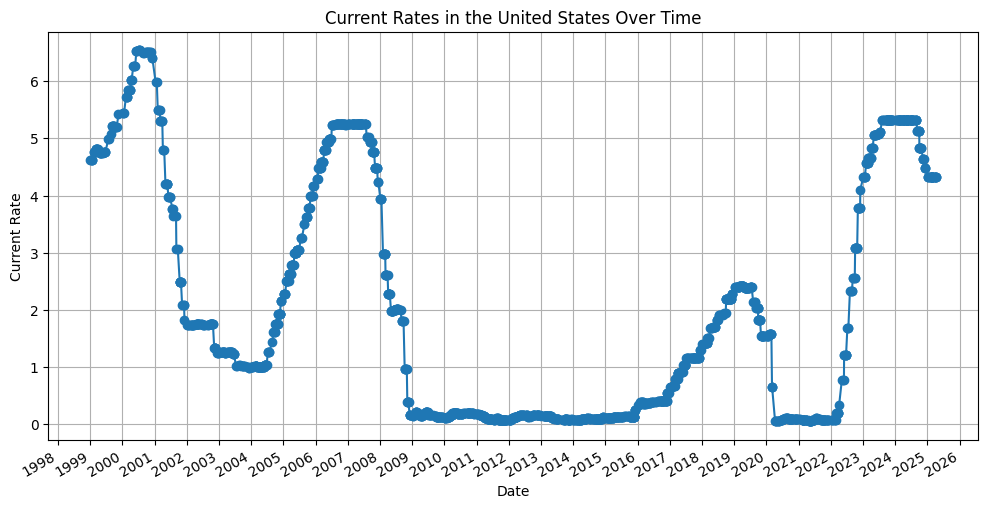

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(levels.index), levels['current_rate'], marker='o', linestyle='-')
plt.title('Current Rates in the United States Over Time')
plt.xlabel('Date')
plt.ylabel('Current Rate')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()

### fix stationarity

In [ ]:
# Function to perform ADF test and check stationarity
def check_adf(df, column_name):
    series = df[column_name].dropna()
    result = adfuller(series)
    stationary = "Yes" if result[1] < 0.05 else "No"
    print(f"{column_name:20} ADF={result[0]: .4f}  p={result[1]: .4f}  Stationary? {stationary}")
    return stationary, result

# Function to fix stationarity for non-stationary series
def fix_stationarity(df, column_name):
    # Perform first differencing
    df[column_name] = df[column_name].diff()
    df = df.dropna()
    return df

In [ ]:
# Iterate until all columns are stationary
differenced = levels.copy()
max_iter = 5  # Prevent infinite loops
for _ in range(max_iter):
    all_stationary = True
    for col in differenced.columns:
        stationary, _ = check_adf(differenced, col)
        if stationary == "No":
            differenced[col] = differenced[col].diff()
            all_stationary = False
    differenced = differenced.dropna()
    if all_stationary:
        break
    else:
        print("Not all series are stationary yet. Continuing...")

print("Final differenced DataFrame head:")
print(differenced.head())

print("Final differenced DataFrame tail:")
print(differenced.tail())

current_rate         ADF=-2.3716  p= 0.1499  Stationary? No
inflation            ADF= 1.2507  p= 0.9963  Stationary? No
unrate               ADF=-2.1963  p= 0.2076  Stationary? No
real_gdp             ADF= 0.2150  p= 0.9731  Stationary? No
yield_spread         ADF=-1.8398  p= 0.3609  Stationary? No
sentiment            ADF=-2.6454  p= 0.0840  Stationary? No
5y_inflation         ADF=-3.5992  p= 0.0058  Stationary? Yes
oil_price            ADF=-3.2885  p= 0.0154  Stationary? Yes
Not all series are stationary yet. Continuing...
current_rate         ADF=-5.6693  p= 0.0000  Stationary? Yes
inflation            ADF=-5.7537  p= 0.0000  Stationary? Yes
unrate               ADF=-11.9727  p= 0.0000  Stationary? Yes
real_gdp             ADF=-14.0479  p= 0.0000  Stationary? Yes
yield_spread         ADF=-16.4569  p= 0.0000  Stationary? Yes
sentiment            ADF=-15.7294  p= 0.0000  Stationary? Yes
5y_inflation         ADF=-3.5990  p= 0.0058  Stationary? Yes
oil_price            ADF=-3.2926  p= 0

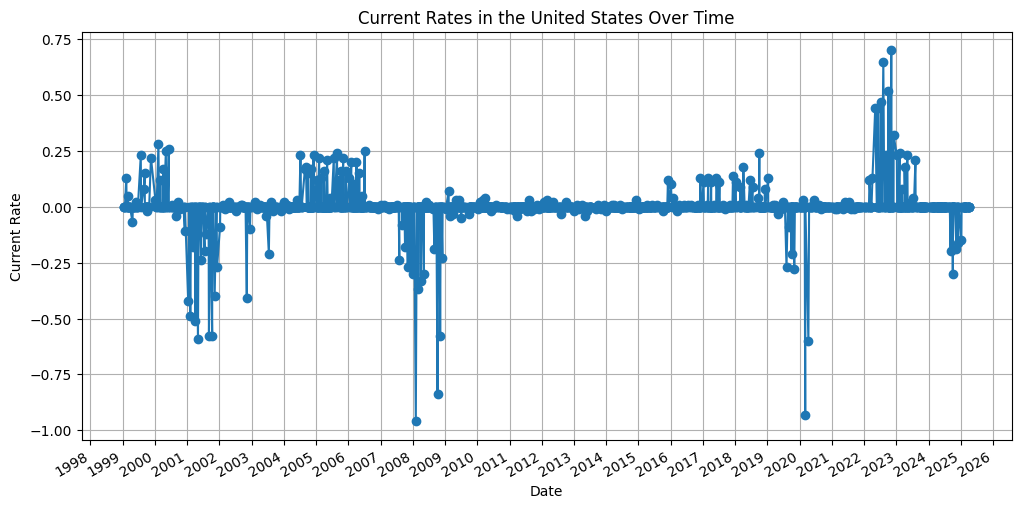

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(differenced.index), differenced['current_rate'], marker='o', linestyle='-')
plt.title('Current Rates in the United States Over Time')
plt.xlabel('Date')
plt.ylabel('Current Rate')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
print('number of rows in differenced:', len(differenced))
print('number of rows in levels:', len(levels))

number of rows in differenced: 1784
number of rows in levels: 1785


### Sarimax

In [ ]:
def run_sarimax_diff(
    levels_df,                    # your original merged DataFrame
    diff_df,                      # the differenced DataFrame
    target_name='current_rate',
    test_size=350,
    order=(1,0,1),
    seasonal_order=(0,0,0,0)
):
    # 1) split diff_df into train/test
    train_diff = diff_df.iloc[:-test_size]
    test_diff  = diff_df.iloc[-test_size:]

    # Ensure both levels_df and diff_df are aligned
    levels_df = levels_df.loc[diff_df.index]

    # 2) split original levels_df at the same cutoff for undifferencing
    cutoff_idx = levels_df.shape[0] - test_size - 1
    last_level = levels_df[target_name].iloc[cutoff_idx]

    # 3) set up exogenous
    exog_vars = [c for c in diff_df.columns if c != target_name]
    exog_train = train_diff[exog_vars]
    exog_test  = test_diff[exog_vars]

    # 4) fit on diffs
    model   = SARIMAX(train_diff[target_name],
                      exog=exog_train,
                      order=order,
                      seasonal_order=seasonal_order)
    results = model.fit(disp=False)

    # 5) forecast *differences*
    fcst_diff = results.get_forecast(steps=test_size,
                                     exog=exog_test).predicted_mean

    # 6) undifference back to levels
    fcst_levels = last_level + fcst_diff.cumsum()

    # ── Key Step: align the forecast index with the test dates ─────────────
    # grab the true test index from the original levels_df
    actual_levels = levels_df[target_name].iloc[-test_size:]
    fcst_levels.index = actual_levels.index

    # 8) compute RMSE on levels
    rmse = mean_squared_error(actual_levels, fcst_levels)

    return fcst_levels, actual_levels, rmse, results

In [ ]:
def plot_forecast(actual, predicted, title='Forecast'):
    plt.figure(figsize=(10, 6))
    actual.plot(label='Actual')
    predicted.plot(label='Forecast', linestyle='--')
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

RMSE: 13.864187760765338
Model Summary:
                               SARIMAX Results                                
Dep. Variable:           current_rate   No. Observations:                 1534
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1952.027
Date:                Sun, 18 May 2025   AIC                          -3884.054
Time:                        17:18:23   BIC                          -3830.698
Sample:                             0   HQIC                         -3864.199
                               - 1534                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
inflation        0.0182      0.004      5.192      0.000       0.011       0.025
unrate          -0.0109      0.005     -2.035      0.042      -0.021      -0.000
real

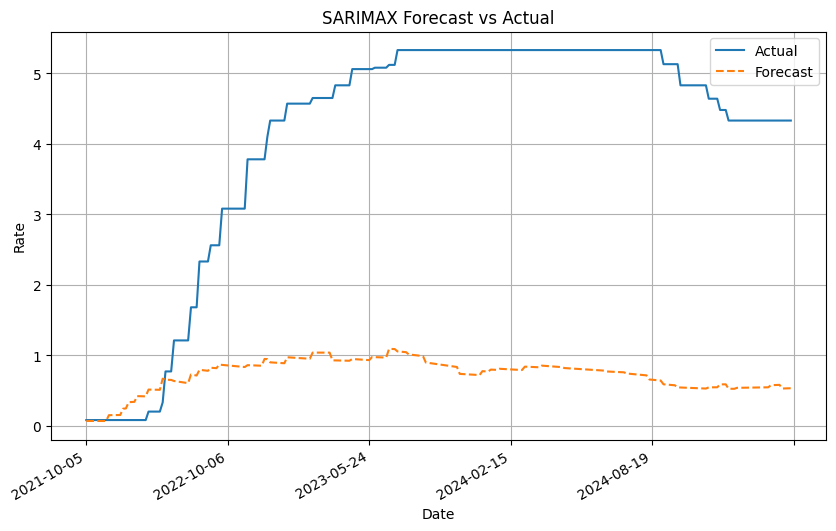

In [ ]:
predicted, actual, rmse, results= run_sarimax_diff(diff_df=differenced, levels_df=levels, target_name='current_rate', test_size=250)
print(f"RMSE: {rmse}")
print(f"Model Summary:\n{results.summary()}")
plot_forecast(actual, predicted, title='SARIMAX Forecast vs Actual')

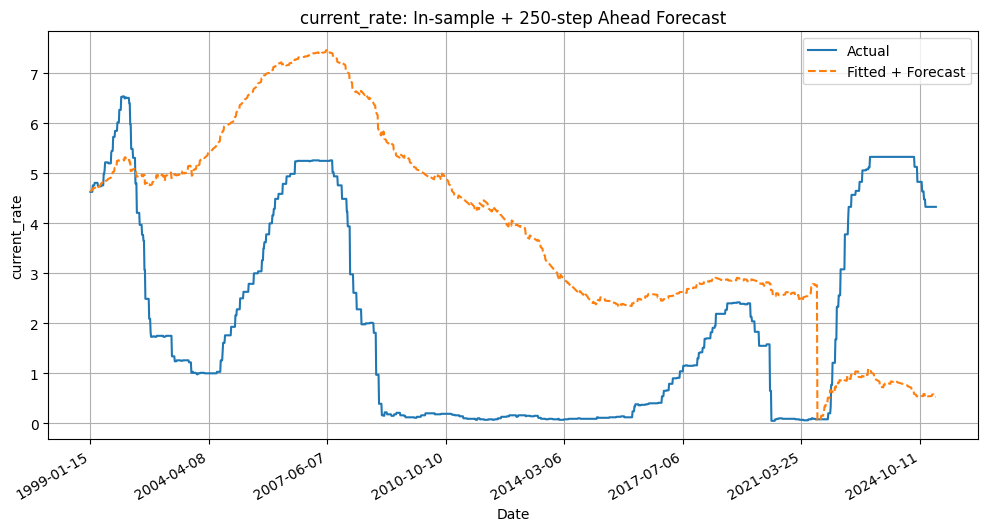

In [ ]:
def plot_full_model(levels_df, diff_df, results,
                    target_name='current_rate', test_size=350):
    """
    levels_df:  original DataFrame of levels, indexed by date
    diff_df:    the first‐differenced DataFrame (levels_df.diff().dropna())
    results:    the fitted SARIMAXResults object
    test_size:  number of steps held out for forecasting
    """
    # --- 1) In‐sample fitted differences
    fitted_diff = results.fittedvalues
    # seed with the very first observed level
    init_level = levels_df[target_name].iloc[0]
    # cumulative sum to recover fitted levels
    fitted_levels = init_level + fitted_diff.cumsum()
    fitted_levels.index = fitted_diff.index

    # --- 2) Out‐of‐sample forecasted differences
    # get last observed level before the test window
    last_level = levels_df[target_name].iloc[-test_size-1]
    # pick exog for the forecast period
    exog_vars = [c for c in diff_df.columns if c != target_name]
    exog_forecast = diff_df[exog_vars].iloc[-test_size:]
    # forecast diffs
    fcst_diff = results.get_forecast(steps=test_size,
                                     exog=exog_forecast).predicted_mean
    # recover levels
    fcst_levels = last_level + fcst_diff.cumsum()
    fcst_levels.index = levels_df.index[-test_size:]

    # --- 3) Combine fitted + forecast
    pred_full = pd.concat([fitted_levels, fcst_levels])

    # --- 4) Plot
    plt.figure(figsize=(12, 6))
    levels_df[target_name].plot(label='Actual')
    pred_full.plot(label='Fitted + Forecast', linestyle='--')
    plt.title(f'{target_name}: In-sample + {test_size}-step Ahead Forecast')
    plt.xlabel('Date')
    plt.ylabel(target_name)
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.show()

plot_full_model(
    levels_df=levels,
    diff_df=differenced,
    results=results,
    target_name='current_rate',
    test_size=250
)

### Adding roberta

In [ ]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import torch

# Load model and tokenizer
model_path   = "roberta_2_class_best_checkpoint"
tokenizer    = RobertaTokenizerFast.from_pretrained(model_path)
model        = RobertaForSequenceClassification.from_pretrained(model_path)
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
df        = pd.read_csv('data/final_v2.csv')
usa_df    = df[df['country']=='United States'][['date','clean_text']]
usa_df['date'] = pd.to_datetime(usa_df['date']).dt.strftime('%Y-%m-%d')

In [ ]:
print(usa_df.head())

         date                                         clean_text
0  1999-01-03  Remarks by Mr Roger W. Ferguson, Jr., a member...
3  1999-01-15  Remarks by Mr Roger W. Ferguson, Jr., a member...
5  1999-01-20  Testimony of the Chairman of the Board of Gove...
6  1999-01-21  Remarks by the President of the Federal Reserv...
7  1999-01-21  Remarks by Mr Roger W Ferguson, Jr, a member o...


In [ ]:
# Aggregate usa_df by date, concatenating clean_text for each date
usa_df_agg = usa_df.groupby('date', as_index=False).agg({'clean_text': ' '.join})

print(usa_df_agg.head())
print('Number of unique dates:', usa_df_agg['date'].nunique())

         date                                         clean_text
0  1999-01-03  Remarks by Mr Roger W. Ferguson, Jr., a member...
1  1999-01-15  Remarks by Mr Roger W. Ferguson, Jr., a member...
2  1999-01-20  Testimony of the Chairman of the Board of Gove...
3  1999-01-21  Remarks by the President of the Federal Reserv...
4  1999-01-26  Summary of a speech by the new President of th...
Number of unique dates: 1785


In [ ]:
usa_df_agg = usa_df_agg.set_index('date')
usa_df = usa_df_agg.sort_index()
print(usa_df.head())

                                                   clean_text
date                                                         
1999-01-03  Remarks by Mr Roger W. Ferguson, Jr., a member...
1999-01-15  Remarks by Mr Roger W. Ferguson, Jr., a member...
1999-01-20  Testimony of the Chairman of the Board of Gove...
1999-01-21  Remarks by the President of the Federal Reserv...
1999-01-26  Summary of a speech by the new President of th...


In [ ]:
# Find duplicated index values (dates) in differenced DataFrame
duplicate_dates = usa_df.index[usa_df.index.duplicated(keep=False)]
print("Duplicate dates in usa_df:", duplicate_dates.unique())

# Show the rows with duplicate dates
print(usa_df.loc[duplicate_dates])

dates = (usa_df.index.nunique())
print(dates)

Duplicate dates in usa_df: Index([], dtype='object', name='date')
Empty DataFrame
Columns: [clean_text]
Index: []
1785


In [ ]:
# 3) Run Roberta inference (batching for speed)
def get_roberta_predictions(texts, tokenizer, model, batch_size=16):
    model.eval()
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        enc = {k: v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
        labels = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(labels.tolist())
    return preds

In [ ]:
texts = usa_df['clean_text'].tolist()
preds = get_roberta_predictions(texts, tokenizer, model)

print(type(preds))
print(len(preds))
print(preds[:5])  # preview first few

<class 'list'>
1785
[1, 1, 1, 1, 1]


In [ ]:
usa_df['roberta_pred'] = preds
print('usa_df:' , usa_df.head())
print('levels:', levels.head())

print('number of rows in usa_df:', len(usa_df))
print('number of rows in levels:', len(levels))

usa_df:                                                    clean_text  roberta_pred
date                                                                       
1999-01-03  Remarks by Mr Roger W. Ferguson, Jr., a member...             1
1999-01-15  Remarks by Mr Roger W. Ferguson, Jr., a member...             1
1999-01-20  Testimony of the Chairman of the Board of Gove...             1
1999-01-21  Remarks by the President of the Federal Reserv...             1
1999-01-26  Summary of a speech by the new President of th...             1
levels:             current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-03          4.63      164.4     4.4  13191.67          0.11   
1999-01-15          4.63      164.4     4.4  13191.67          0.11   
1999-01-20          4.63      164.4     4.4  13191.67          0.11   
1999-01-21          4.63      164.4     4.4  13191.67          0.11   
1999-01-26          4.63  

In [ ]:
levels_with_roberta = levels.merge(usa_df, on="date", how="left")
print(levels_with_roberta.head())

            current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-03          4.63      164.4     4.4  13191.67          0.11   
1999-01-15          4.63      164.4     4.4  13191.67          0.11   
1999-01-20          4.63      164.4     4.4  13191.67          0.11   
1999-01-21          4.63      164.4     4.4  13191.67          0.11   
1999-01-26          4.63      164.4     4.4  13191.67          0.11   

            sentiment  5y_inflation  oil_price  \
date                                             
1999-01-03      100.5          1.49      12.14   
1999-01-15      100.5          1.49      12.14   
1999-01-20      100.5          1.49      12.14   
1999-01-21      100.5          1.49      12.14   
1999-01-26      100.5          1.49      12.14   

                                                   clean_text  roberta_pred  
date                                                                     

In [ ]:
# 5) Prepare new levels SARIMAX:
levels_with_roberta = levels_with_roberta.drop(columns=["clean_text"])
print(levels_with_roberta.head())

            current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-03          4.63      164.4     4.4  13191.67          0.11   
1999-01-15          4.63      164.4     4.4  13191.67          0.11   
1999-01-20          4.63      164.4     4.4  13191.67          0.11   
1999-01-21          4.63      164.4     4.4  13191.67          0.11   
1999-01-26          4.63      164.4     4.4  13191.67          0.11   

            sentiment  5y_inflation  oil_price  roberta_pred  
date                                                          
1999-01-03      100.5          1.49      12.14             1  
1999-01-15      100.5          1.49      12.14             1  
1999-01-20      100.5          1.49      12.14             1  
1999-01-21      100.5          1.49      12.14             1  
1999-01-26      100.5          1.49      12.14             1  


In [ ]:
# Iterate until all columns are stationary
differenced = levels_with_roberta.copy()
max_iter = 5  # Prevent infinite loops
for _ in range(max_iter):
    all_stationary = True
    for col in differenced.columns:
        stationary, _ = check_adf(differenced, col)
        if stationary == "No":
            differenced[col] = differenced[col].diff()
            all_stationary = False
    differenced = differenced.dropna()
    if all_stationary:
        break
    else:
        print("Not all series are stationary yet. Continuing...")

print("Final differenced DataFrame head:")
print(differenced.head())

print("Final differenced DataFrame tail:")
print(differenced.tail())

current_rate         ADF=-2.3716  p= 0.1499  Stationary? No
inflation            ADF= 1.2507  p= 0.9963  Stationary? No
unrate               ADF=-2.1963  p= 0.2076  Stationary? No
real_gdp             ADF= 0.2150  p= 0.9731  Stationary? No
yield_spread         ADF=-1.8398  p= 0.3609  Stationary? No
sentiment            ADF=-2.6454  p= 0.0840  Stationary? No
5y_inflation         ADF=-3.5992  p= 0.0058  Stationary? Yes
oil_price            ADF=-3.2885  p= 0.0154  Stationary? Yes
roberta_pred         ADF=-4.1356  p= 0.0008  Stationary? Yes
Not all series are stationary yet. Continuing...
current_rate         ADF=-5.6693  p= 0.0000  Stationary? Yes
inflation            ADF=-5.7537  p= 0.0000  Stationary? Yes
unrate               ADF=-11.9727  p= 0.0000  Stationary? Yes
real_gdp             ADF=-14.0479  p= 0.0000  Stationary? Yes
yield_spread         ADF=-16.4569  p= 0.0000  Stationary? Yes
sentiment            ADF=-15.7294  p= 0.0000  Stationary? Yes
5y_inflation         ADF=-3.5990  p= 0

RMSE (with roberta): 14.200598120835908
Model Summary (with roberta):
                               SARIMAX Results                                
Dep. Variable:           current_rate   No. Observations:                 1534
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1955.040
Date:                Sun, 18 May 2025   AIC                          -3888.080
Time:                        17:56:48   BIC                          -3829.388
Sample:                             0   HQIC                         -3866.240
                               - 1534                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
inflation        0.0197      0.004      5.285      0.000       0.012       0.027
unrate          -0.0109      0.006     -1.887      0.05

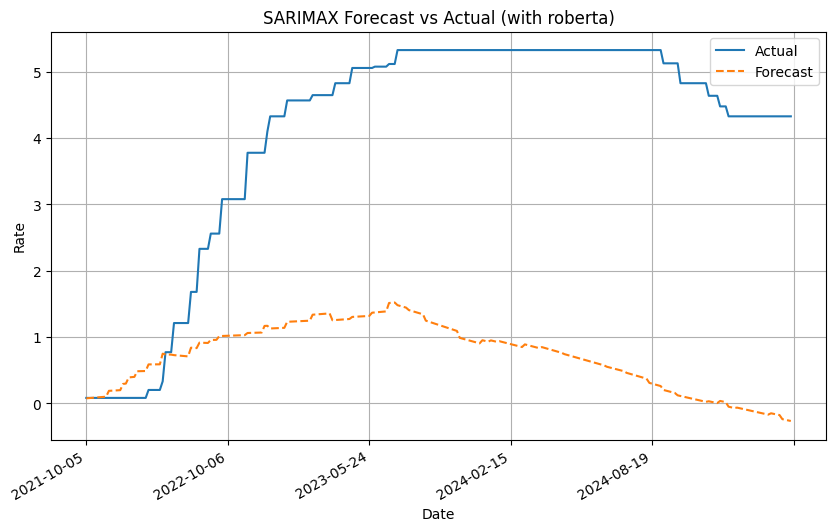

In [ ]:
predicted, actual, rmse, results= run_sarimax_diff(diff_df=differenced, levels_df=levels_with_roberta, target_name='current_rate', test_size=250)
print(f"RMSE (with roberta): {rmse}")
print(f"Model Summary (with roberta):\n{results.summary()}")
plot_forecast(actual, predicted, title='SARIMAX Forecast vs Actual (with roberta)')

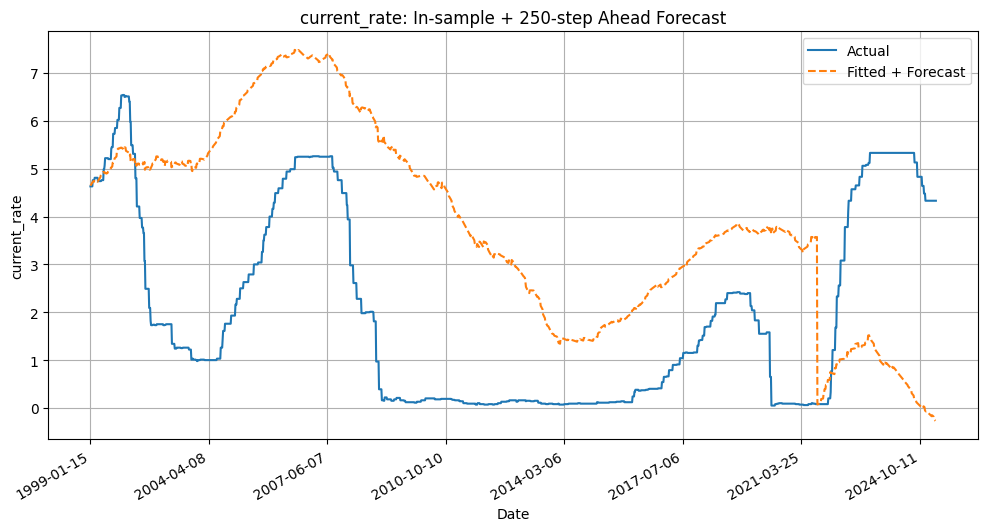

In [ ]:
def plot_full_model(levels_df, diff_df, results,
                    target_name='current_rate', test_size=350):
    """
    levels_df:  original DataFrame of levels, indexed by date
    diff_df:    the first‐differenced DataFrame (levels_df.diff().dropna())
    results:    the fitted SARIMAXResults object
    test_size:  number of steps held out for forecasting
    """
    # --- 1) In‐sample fitted differences
    fitted_diff = results.fittedvalues
    # seed with the very first observed level
    init_level = levels_df[target_name].iloc[0]
    # cumulative sum to recover fitted levels
    fitted_levels = init_level + fitted_diff.cumsum()
    fitted_levels.index = fitted_diff.index

    # --- 2) Out‐of‐sample forecasted differences
    # get last observed level before the test window
    last_level = levels_df[target_name].iloc[-test_size-1]
    # pick exog for the forecast period
    exog_vars = [c for c in diff_df.columns if c != target_name]
    exog_forecast = diff_df[exog_vars].iloc[-test_size:]
    # forecast diffs
    fcst_diff = results.get_forecast(steps=test_size,
                                     exog=exog_forecast).predicted_mean
    # recover levels
    fcst_levels = last_level + fcst_diff.cumsum()
    fcst_levels.index = levels_df.index[-test_size:]

    # --- 3) Combine fitted + forecast
    pred_full = pd.concat([fitted_levels, fcst_levels])

    # --- 4) Plot
    plt.figure(figsize=(12, 6))
    levels_df[target_name].plot(label='Actual')
    pred_full.plot(label='Fitted + Forecast', linestyle='--')
    plt.title(f'{target_name}: In-sample + {test_size}-step Ahead Forecast')
    plt.xlabel('Date')
    plt.ylabel(target_name)
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.show()

plot_full_model(
    levels_df=levels_with_roberta,
    diff_df=differenced,
    results=results,
    target_name='current_rate',
    test_size=250
)